This file is loosely inspired by the tutorial based on:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

Some of the code in this file is generated by ChatGPT

This file makes use of the MIT-BIH Database

# Dependencies

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import wfdb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

import time
import csv
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

import re


# Load the dataset

The MIT-BIH dataset contains 48 half-hour samples of ECG recordings

Each recording corresponds to three raw files:

1. `.hea` describes the recording's sampling rate, channels, etc.
2. `.dat` are a sequence of 12-bit integers encoding the intensity at 360 Hz with a resolution of 1/200 mV
    - there are two channels, but only the first one is consistent
3. `.atr` includes the time stamp and type of each heartbeat

In [2]:
dl_path = "./raw_data/"
lof = []
for p in os.listdir(dl_path):
    if 'atr' in p:
        lof.append(int(p.split('.')[0]))

In [3]:
# contains paced beats
excludedNames = [102, 104, 107, 217]

# set records to be included here
recordNames = []
for l in lof:
    if (l not in excludedNames):
        recordNames.append(l)
#recordNames = [100, 101, 103, 105, 106, 108, 109, 111, 112]
#recordNames = [100, 101]

print(recordNames)

# window size for each record
windowSize = 290

batch_size = 512
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")

seed = 22
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

[231, 109, 115, 220, 122, 210, 234, 221, 118, 205, 119, 213, 201, 214, 124, 233, 123, 111, 113, 207, 112, 215, 203, 219, 114, 232, 108, 209, 103, 200, 117, 223, 101, 106, 116, 100, 222, 121, 202, 208, 212, 105, 228, 230]


In [4]:
numRec = len(recordNames)

for i in range(numRec):
    recordNames[i] = str(recordNames[i])

print("Number of records: %d" % numRec)

Number of records: 44


# Read the files

The `.dat` file's encoding is automatically converted to double floats in mV when we read it

The `.atr` is read into an object with an array of true labels and an array of time stamps

In [5]:
annos = [] # annotation
records = []

for i in range(numRec):
    annos.append(wfdb.rdann(dl_path + recordNames[i], 'atr'))
    records.append(wfdb.rdrecord(dl_path + recordNames[i]))

print(len(annos[i].sample), len(annos[i].symbol))
    
signals = []
for i in range(numRec):
    # we'll worry about quantization later in the code
    signals.append(records[i].p_signal.astype(np.float32))

2466 2466


## Heartbeat Segmentation

We want each heartbeat in the records to be one data point, those data points should then be shuffled (instead of being grouped by patient)

In [6]:
# N:0 S:1 V:2 F:3 Q:4; 4 is unclassifiable
labelMap = {
    'N':0,'L':0,'R':0,'e':0,'j':0,
    'A':1,'a':1,'J':1,'S':1,
    'V':2,'E':2,
    'F':3,
    'Q':4,'/':4,'?':4,'f':4,'P':4,'t':4
}

In [7]:
beats = []
labelChars = [] # label still in strings
for i in range(numRec):
    for pos, label in zip(annos[i].sample, annos[i].symbol):
        if (label not in labelMap.keys()):
            continue
        winMin = pos - windowSize//2
        winMax = pos + windowSize//2
        if (winMin >=0 and winMax <= len(signals[i])): # this will sacrifice some signals
            segment = signals[i][pos - windowSize//2 : pos + windowSize//2, 0] # channel 0 only
            beats.append(segment)
            labelChars.append(label)

beats = np.stack(beats) # shape: total number of beats * window size
print("Shape of beats:", len(beats), len(beats[0]))

Shape of beats: 100688 290


AAMI suggests five categories out of the multitude of labels from MIT-BIH, we encode them into integers

In [8]:

labels = [labelMap.get(_x, -1) for _x in labelChars]

print(set(labels))

{0, 1, 2, 3, 4}


## Data Augmentation

In [9]:
# by deepseek
def augment_classes_by_label(values, labels, labels_to_augment, duplication_factor):
    values = np.asarray(values)
    labels = np.asarray(labels)
    
    if len(values) != len(labels):
        raise ValueError("Values and labels must have the same length")
    
    if duplication_factor < 1:
        raise ValueError("Duplication factor must be >= 1")
    
    # Initialize lists to collect augmented data
    aug_values_list = [values]
    aug_labels_list = [labels]
    
    # For each label to augment
    for label in labels_to_augment:
        if label not in labels:
            continue
            
        # Get mask for this label
        mask = labels == label
        
        # Duplicate (duplication_factor - 1) times
        for _ in range(duplication_factor - 1):
            aug_values_list.append(values[mask])
            aug_labels_list.append(labels[mask])
    
    # Concatenate all parts
    augmented_values = np.concatenate(aug_values_list, axis=0)
    augmented_labels = np.concatenate(aug_labels_list, axis=0)
    
    return augmented_values, augmented_labels

In [10]:
aBeats, aLabels = augment_classes_by_label(beats, labels, [1, 2, 3, 4], 10)

tally = {0:0, 1:0, 2:0, 3:0, 4:0}
for l in aLabels:
    tally[l] += 1
print(tally)

{0: 90082, 1: 27810, 2: 70080, 3: 8020, 4: 150}


## Spike Generation

In [11]:
def normalize(x):
    x_min = x.min()
    x_max = x.max()
    return (x - x_min) / (x_max - x_min + 1e-8)

### Derivative

Using the derivative is sometimes helpful

In [12]:
# by ChatGPT
def dvdt(x: torch.Tensor) -> torch.Tensor:
    if x.ndim != 3:
        raise ValueError(f"Expected a 3D tensor (time, batch, inputs), got {x.ndim}D.")
    
    dx = x[1:] - x[:-1]
    zero_frame = torch.zeros(1, *x.shape[1:], dtype=x.dtype, device=x.device)
    dx = torch.cat((dx, zero_frame), dim=0)
    return dx

### deltas

We can work with just the positive edge, or both

In [13]:
# expecting an input of num_steps x batch x 1
# returning either nxbx1 or nxbx2

# snnTorch: if (data[n+1] - data[n] > thr): spike
def delta_snt(data, deltaThr, negEdge=False):
    if (not negEdge):
        return spikegen.delta(data, threshold=deltaThr)
    
    spikeDataP = spikegen.delta(data, threshold=deltaThr)
    spikeDataN = spikegen.delta(-data, threshold=deltaThr)
    spikeData = torch.cat((spikeDataP, spikeDataN), dim=2)
    return spikeData

# alternative: if (data[n] - data[prevSpike] > thr): spike
def delta_alt(data, deltaThr, negEdge=False):
    if (not negEdge):
        spikes = torch.zeros_like(data)
        for b in range(data.size(1)):
            prevSpike = 0
            for n in range(data.size(0)):
                if ((data[n, b, 0] - data[prevSpike, b, 0]) > deltaThr):
                    spikes[n, b, 0] = 1
                    prevSpike = n
        return spikes
    else:
        # ChatGPT impl.
        timesteps, batches, inputs = data.shape

        # Initialize output spike signals with zeros
        pos_spikes = torch.zeros_like(data, device=device)
        neg_spikes = torch.zeros_like(data, device=device)
    
        # Initialize delta_sample as the first sample for each batch
        delta_sample = data[0].clone()
    
        for t in range(timesteps):
            x = data[t]
    
            # Positive spike detection
            pos_mask = x > delta_sample + deltaThr
            pos_spikes[t, pos_mask] = 1.0  # spike
            delta_sample[pos_mask] = x[pos_mask]
    
            # Negative spike detection
            neg_mask = x < delta_sample - deltaThr
            neg_spikes[t, neg_mask] = 1.0  # spike
            delta_sample[neg_mask] = x[neg_mask]
 
        spikeData = torch.cat((pos_spikes, neg_spikes), dim=2)
        return spikeData
        

## Dataset and Loader

In [14]:
def normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    
    # Avoid division by zero if all values are equal
    if max_val == min_val:
        return torch.zeros_like(tensor)
    
    normalized = (tensor - min_val) / (max_val - min_val)
    return normalized

def normalize3(tensor, min_val, max_val):
    # Avoid division by zero if all values are equal
    if max_val == min_val:
        return torch.zeros_like(tensor)
    
    normalized = (tensor - min_val) / (max_val - min_val)
    return normalized

In [15]:
class Spike_Dataset(Dataset):
    def __init__(self, beatsT, labelsT, deltaThr1, deltaThr2,
                 t=torch.float32):
        self.labels = torch.tensor(labelsT, dtype=torch.long).to(device)

        data = torch.tensor(beatsT)
        self.beats = normalize(data)
        data = (data.unsqueeze(0)).permute(2, 1, 0)

        d = normalize(data)
        ddt = normalize(dvdt(data))
        ddt2 = normalize(dvdt(dvdt(data)))
        
        spikeData0 = delta_alt(d, deltaThr1, True)
        spikeData1 = delta_alt(ddt, deltaThr2, True)
        spikeData2 = delta_alt(ddt2, deltaThr2, True)
        spikeData = torch.cat((spikeData0, spikeData1, spikeData2),
                              dim=2)
        
        self.spikes = spikeData.to(device)
        
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.spikes[:, idx, :], self.labels[idx]
    def shapes(self):
        print(self.spikes.shape, self.labels.shape)
    def getBeat(self, idx):
        return self.beats[idx]


dataset = Spike_Dataset(aBeats, aLabels, 0.003, 0.006)
dataset.shapes()
dataset[74][0].size()

torch.Size([290, 196142, 6]) torch.Size([196142])


torch.Size([290, 6])

In [16]:
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, 
                                                      [train_size, 
                                                       valid_size, 
                                                       test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                          shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, drop_last=False)

print(train_size, len(train_loader))
print(valid_size, len(valid_loader))
print(test_size, len(test_loader))



137299 268
19614 39
39229 77


## Data Visualisation

In [17]:
def plot_spikes(spike_data, k=1):
    fig = plt.figure(facecolor="w", figsize=(8, 1))
    ax = fig.add_subplot(111)
    splt.raster(spike_data, ax, c="black")
    plt.title("Input Neuron")
    plt.xlabel("Time step")
    plt.yticks([])
    plt.xlim(0, windowSize*k)
    plt.show()

def plot_beat(data):
    data = data.clone().cpu().detach().numpy()
    plt.plot(data)

    plt.title("beat")
    plt.xlabel("Time step")
    plt.ylabel("Voltage (mV)")
    plt.ylim(0, 1)
    plt.show()

# accepts 360 beats and 360x6 spike-candidates
def plot_beat_spikes(beat, spikes):
    beat = beat.clone().cpu().detach().numpy()
    spikes = spikes.clone().cpu().detach().numpy().astype(bool)

    # Create x-axis
    x = np.arange(len(beat))
    
    # Plot the line for the float values
    plt.plot(x, beat, label="beats", color="blue")

    offset = 0.9
    # plot all types of spikes
    for i in range(len(spikes[0])):
        # Plot scatter points where flags are True
        plt.scatter(x[spikes[:, i]], np.zeros(sum(spikes[:, i]))+ offset, 
                    color="red", label="spikes", zorder=3, s=4)
        offset -= 0.1

    # Make it look nice
    plt.xlabel("time")
    plt.ylabel("mV")
    plt.title("Line and Boolean Scatter Plot")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.ylim(0, 1)
    plt.show()

-----
showcasing sample 36796
truth class: tensor(0, device='cuda:0')


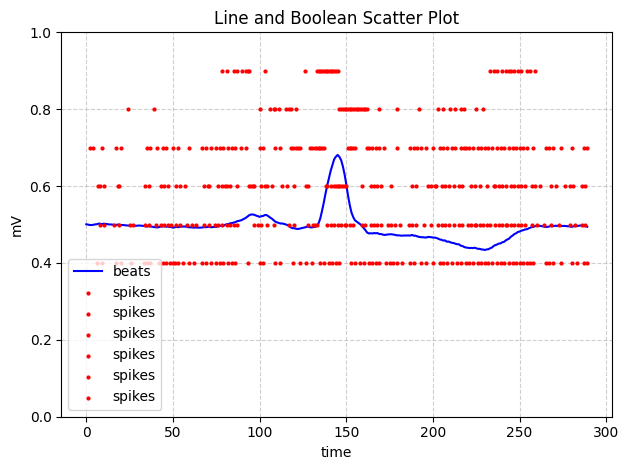

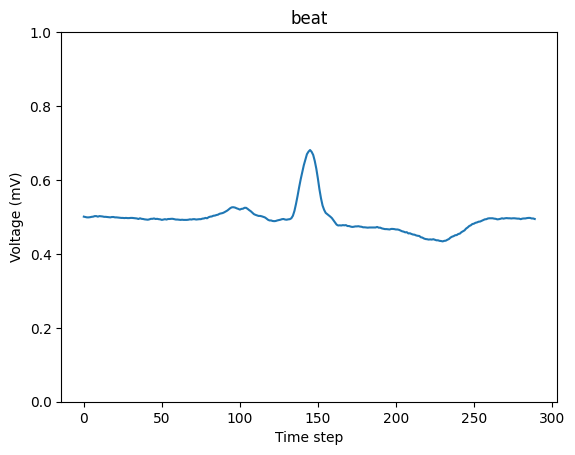

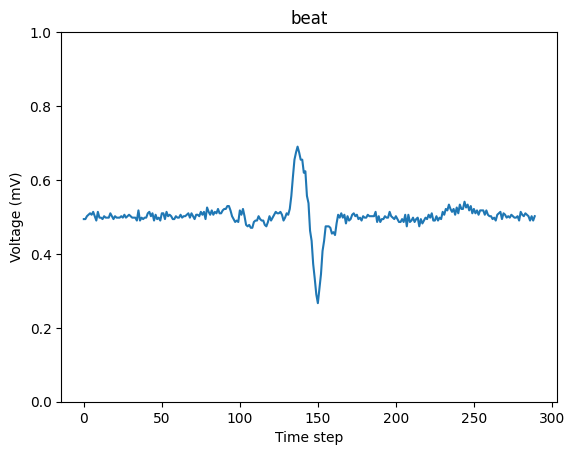

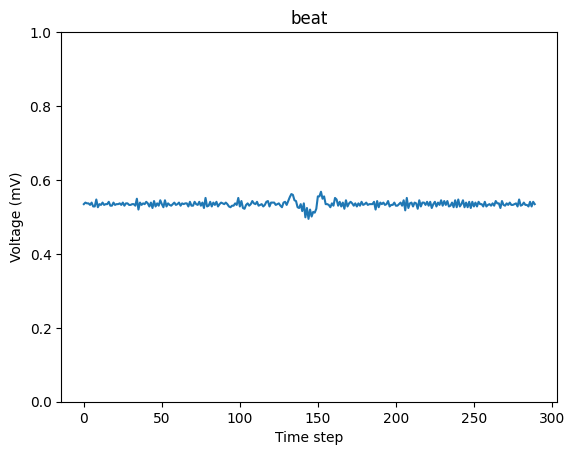

In [18]:
for i in range(1):
    print("-----")
    
    ri = random.randint(0, len(dataset))
    
    
    print("showcasing sample", ri)
    print("truth class:", dataset[ri][1])

    
    plot_beat_spikes(dataset.getBeat(ri), dataset[ri][0])


    data = aBeats
    data = torch.tensor(data)
    data = (data.unsqueeze(0)).permute(2, 1, 0)

    d = normalize(data) 
    plot_beat(d[:, ri, 0])

    ddt = normalize(dvdt(data))
    plot_beat(ddt[:, ri, 0])

    ddt2 = normalize(dvdt(dvdt(data)))
    plot_beat(ddt2[:, ri, 0])

# Define the Network(s)

## SNN_Baseline

In [19]:
# accepts a tensor of num_steps×batchx1
class SNN_Baseline(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6):
        super().__init__()
        self.name = "SNN_Baseline"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = 2
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta)
        self.fc2 = nn.Linear(64, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta)

    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant

            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            cur2 = self.fc2(spk1)
            cur2 = torch.clamp(cur2, 0, None)
            
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            spkx_rec.append(spk2)
            memx_rec.append(mem2)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)

## SNN_Big

In [20]:
# accepts a tensor of num_steps×batchx1
class SNN_Big(nn.Module):
    def __init__(self, beta=0.95, qbits = 8, fbits = 6, num_inputs_p = 2):
        super().__init__()
        self.name = "SNN_Big"
        
        # Temporal Dynamics
        self.beta = beta

        # ensure all internal operations are done on fixed point
        self.quant = False
        # the total number of bits we can use
        self.qbits = qbits
        self.fbits = fbits # the number of bits representing fractions
        
        # Network Architecture
        num_inputs = num_inputs_p
        num_outputs = 5 # five classes

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, 64, bias=False)
        self.lif1 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc2 = nn.Linear(64, 128, bias=False)
        self.lif2 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc3 = nn.Linear(128, 64, bias=False)
        self.lif3 = snn.Leaky(beta=self.beta, reset_mechanism='zero')
        self.fc4 = nn.Linear(64, num_outputs, bias=False)
        self.lif4 = snn.Leaky(beta=self.beta, reset_mechanism='zero')


    # quantize any tensor according to the model's rules
    def quantize(self, x):
        if (not self.quant):
            return x
        # e.g. quantize 1.1 with 4 bits incl. 2 fraction bits, 2's complement:
        # 1. find the upper and lower bounds 0b(01.11)=1.75; 0b(10.00)=-2
        # 2. clamp it if necessary
        # 3. scale it by 2^3=8 => 1.1*8=8.8
        # 4. round it to a whole number: round(8.8)=9=0b1001
        # 5. scale back 9/8=1.125=0b(1.001) which is the closest we can do
        # boundary check        
        scale = 1 << self.fbits
        
        ub = ((1 << (self.qbits-1))-1) / scale
        lb = ((1 << (self.qbits-1))*-1)/ scale
        x = torch.clamp(x, lb, ub)
        
        x = x *scale 
        x = torch.round(x)
        
        x = x / scale

        return x

    # toggle quantized mode, irreversible for now
    def quant_mode(self):
        if (not self.quant):
            self.quant = True
            self.fc1.weight.data = self.quantize(self.fc1.weight.data)
            self.fc2.weight.data = self.quantize(self.fc2.weight.data)
            self.fc3.weight.data = self.quantize(self.fc3.weight.data)
            self.fc4.weight.data = self.quantize(self.fc4.weight.data)

    # can report the hidden value for logging
    def forward(self, x, num_steps, hidden=False):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        mem1_rec = []
        
        # Record the final layer
        spkx_rec = []
        memx_rec = []

        # Feed in the spikes of the entire batch at a given time step in parallel
        for step in range(num_steps):
            # the weights are already quant'd, no need to quant spikes
            cur1 = self.fc1(x[step])
            # the resulting multiple is still quant'd
            #cur1 = torch.clamp(cur1, 0, None) # room for optimisation for quant
            # potential quant bug: depending on how the currents are summed up they
            # will have the same precision, but can exceed the upper bound
            spk1, mem1 = self.lif1(cur1, mem1)
            # consistently quant mem1 after use
            mem1 = self.quantize(mem1)
            
            cur2 = self.fc2(spk1)
            #cur2 = torch.clamp(cur2, 0, None)
            spk2, mem2 = self.lif2(cur2, mem2)
            # consistently quant mem2 after use
            mem2 = self.quantize(mem2)
            
            cur3 = self.fc3(spk2)
            #cur3 = torch.clamp(cur3, 0, None)
            spk3, mem3 = self.lif3(cur3, mem3)
            # consistently quant mem3 after use
            mem3 = self.quantize(mem3)

            cur4 = self.fc4(spk3)
            #cur4 = torch.clamp(cur4, 0, None)
            spk4, mem4 = self.lif4(cur4, mem4)
            # consistently quant mem4 after use
            mem4 = self.quantize(mem4)
            
            spkx_rec.append(spk4)
            memx_rec.append(mem4)

            
            if (hidden):
                mem1_rec.append(mem1)
        
        if (hidden):
            mem1_rec = torch.stack(mem1_rec, dim=0)
        else:
            mem1_rec = None

        return (torch.stack(spkx_rec, dim=0),
                torch.stack(memx_rec, dim=0),
                mem1_rec)


# Quantization Demo

In [21]:
# A quantized number should be whole when shifted

def quant_sanity(x, fbits):
    # assisted by ChatGPT
    x = x * (2**fbits)
    return torch.all(x == torch.round(x)).item()

# temporary net for demo
tnet = SNN_Baseline(0, 8, 6)

print((tnet.fc1.weight.data * (2 ** tnet.fbits))[:2, :2])

tnet.quant_mode()
print((tnet.fc1.weight.data * (2 ** tnet.fbits))[:2, :2])

x = torch.tensor([1, 0.11, -0.34, 0.004, -1])
print(quant_sanity(x, tnet.fbits))
x = tnet.quantize(x)

print(x)

print(quant_sanity(x, tnet.fbits))

tnet=None

tensor([[-10.4144,  42.5214],
        [-27.1239,   6.2132]])
tensor([[-10.,  43.],
        [-27.,   6.]])
False
tensor([ 1.0000,  0.1094, -0.3438,  0.0000, -1.0000])
True


# Evaluation Functions

In [22]:
# by chatgpt

def f1_score(y_true: torch.Tensor, y_pred: torch.Tensor, average: str = 'macro') -> float:
    """
    Compute the F1 score between true and predicted labels.
    
    Args:
        y_true (torch.Tensor): Ground truth labels, shape (N,)
        y_pred (torch.Tensor): Predicted labels, shape (N,)
        average (str): 'macro', 'micro', or 'weighted'
    
    Returns:
        float: The F1 score.
    """
    # Ensure tensors are 1D and same shape
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"

    classes = torch.unique(y_true)
    f1_scores = []

    for cls in classes:
        tp = torch.sum((y_pred == cls) & (y_true == cls)).item()
        fp = torch.sum((y_pred == cls) & (y_true != cls)).item()
        fn = torch.sum((y_pred != cls) & (y_true == cls)).item()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        f1_scores.append(f1)

    f1_scores = torch.tensor(f1_scores)

    if average == 'macro':
        return f1_scores.mean().item()
    elif average == 'micro':
        # Micro-average over all classes
        tp = torch.sum(y_true == y_pred).item()
        total = len(y_true)
        return tp / total  # This is accuracy, equivalent to micro-F1 when labels are balanced
    elif average == 'weighted':
        supports = torch.tensor([(y_true == cls).sum().item() for cls in classes], dtype=torch.float)
        return (f1_scores * supports / supports.sum()).sum().item()
    else:
        raise ValueError("average must be one of 'macro', 'micro', or 'weighted'")

## loss functions

In [23]:
class SpikeRate(torch.nn.Module):
    def __init__(self, true_rate, false_rate, reduction="sum"):
        super().__init__()
        self.true_rate = true_rate
        self.false_rate = false_rate
        self.reduction = reduction

    def forward(self, input, label):
        # TBN → BNT
        input = input.permute(1, 2, 0).contiguous()
        input = input.view(input.shape[0], -1, input.shape[-1])

        label = label.to(input.device)

        spike_rate = torch.mean(input, dim=-1)

        with torch.no_grad():
            one_hot = F.one_hot(label, num_classes=input.shape[1]).float()
            target_rate = (
                self.true_rate * one_hot
                + self.false_rate * (1 - one_hot)
            )

        return F.mse_loss(
            spike_rate,
            target_rate,
            reduction=self.reduction
        )


In [24]:
# by chatGPT

def exp_psp_kernel(tau, dt, kernel_size, device):
    """
    Causal exponential PSP kernel.
    """
    t = torch.arange(kernel_size, device=device) * dt
    kernel = torch.exp(-t / tau)
    kernel /= kernel.sum()  # normalize energy
    return kernel
    
def num_spikes_loss(
    spk_out,              # [T, B, N]
    target_labels,        # [B]
    start_t,
    stop_t,
    tgt_spike_count_true,
    tgt_spike_count_false,
    tau_psp=10.0,         # PSP time constant (ms)
    psp_kernel_size=50,   # kernel length (timesteps)
    scale=1.0,
    dt=1.0,
):
    """
    SLAYER-style spike count loss with PSP filtering (label-based).
    """

    T, B, N = spk_out.shape
    device = spk_out.device

    mask = torch.zeros_like(spk_out)
    mask[start_t:stop_t] = 1.0

    actual_spikes = (
        spk_out[start_t:stop_t]
        .sum(dim=0, keepdim=True)   # [1, B, N]
        .detach()
        * dt
    )

    desired_spikes = torch.full(
        (1, B, N),
        tgt_spike_count_false,
        device=device,
    )

    desired_spikes[
        0,
        torch.arange(B, device=device),
        target_labels
    ] = tgt_spike_count_true

    count_error = (
        (actual_spikes - desired_spikes)
        / (stop_t - start_t)
        * scale
    )

    spk_desired = spk_out * mask
    timing_error = spk_out - spk_desired   # spikes outside window

    psp_kernel = exp_psp_kernel(
        tau=tau_psp,
        dt=dt,
        kernel_size=psp_kernel_size,
        device=device,
    )

    # Reshape for grouped 1D convolution
    # [T, B, N] → [B, N, T]
    timing_error = timing_error.permute(1, 2, 0)

    timing_error = F.conv1d(
        timing_error,
        psp_kernel.view(1, 1, -1).repeat(N, 1, 1),
        padding=psp_kernel_size - 1,
        groups=N,
    )

    # Back to [T, B, N]
    timing_error = timing_error[:, :, :T].permute(2, 0, 1)

    error = timing_error + count_error * mask

    return 0.5 * (error ** 2).sum() * dt
    
celoss = nn.CrossEntropyLoss()
slayerLoss = SpikeRate(0.2, 0.03)

def get_loss_wrapper(spk_out, target_labels):
    if False:
        return num_spikes_loss(spk_out, target_labels, 150, 290, 48, 9)
    elif True:
        return slayerLoss(spk_out, target_labels)
    else:
        # initialize the loss & sum over time
        loss_val = celoss(spk_out.sum(dim=0), target_labels)
        return loss_val
                     
def plot_loss(loss_hist):
    fig = plt.figure(facecolor="w", figsize=(10, 5))

    window = 200
    kernel = np.ones(window) / window
    loss_smooth = np.convolve(loss_hist, kernel, mode='same')

    plt.plot(loss_hist)
    plt.plot(loss_smooth)
    plt.title("Loss Curves")
    plt.legend(["Train Loss", "Smooth Loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


## Evaluator

In [25]:
def evaluate(net, targetRegion, eval_loader, quant=False, printOut=True):
    total = 0
    correct = 0

    num_steps = windowSize

    totalLabels = []
    totalPredictions = []

    totalLoss = 0
    
    with torch.no_grad():
        net.eval()
        if (quant):
            net.quant_mode()
        counter = 0
        for data, targets in eval_loader:
            data = data.to(device)
            targets = targets.to(device)

            data = data.permute(1, 0, 2)
            # spikeData should be in (num_steps)xbatchxinputs

            # forward pass
            test_spk, mem_rec, mem1_rec = net(data, num_steps, True)

            # sample plots
            if (random.randint(0, 10000) < 800) and False:
                pass
    
            test_spk = test_spk[targetRegion[0]:targetRegion[1]]
        
            #print(test_spk.sum(dim=0))
            # calculate total accuracy
            _, predicted = test_spk.sum(dim=0).max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            if False:
                print(test_spk.sum(dim=0))
    
            totalLabels.append(targets)
            totalPredictions.append(predicted)

            #loss_val = torch.zeros((1), dtype=torch.float32, device=device)
            #for step in range(targetRegion[0], targetRegion[1]):
            #    loss_val += loss(mem_rec[step], targets)
            loss_val = get_loss_wrapper(test_spk, targets)
            totalLoss += loss_val.item()

            counter += 1
            print("\rEvaluated %d / %d   " % (counter, len(eval_loader)),
                 end='', flush=True)

    print(f"Total correctly classified: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
    if (printOut):
        # Confusion Matrix
        truth = torch.cat(totalLabels)
        pred = torch.cat(totalPredictions)
    
        confusion_mat = confusion_matrix(truth.cpu(), pred.cpu())

        print("F1:", f1_score(truth.cpu(), pred.cpu()))
    
        # Display the confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat,
                    annot=True,
                    fmt="d",
                    cmap="Blues",
                    xticklabels=[f"Class {i}" for i in range(5)],
                    yticklabels=[f"Class {i}" for i in range(5)])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
    
    return (correct / total), totalLoss



# The Training Function

In [26]:
def train_net(net, lr, targetRegion, num_epochs):

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-5)

    # each sample in the window can generate multiple spikes for rate encoding
    num_steps = windowSize

    # history of losses
    loss_hist = []
    validLoss_hist = []
    minLoss = 5e30
    patience = 0
    
    # Outer training loop
    for epoch in range(num_epochs):
        train_batch = iter(train_loader)
        counter = 0
    
        # Minibatch training loop
        for data, targets in train_batch:
            #data = data.to(device)
            #targets = targets.to(device)

            # data is batch x window x inputs, we need them in w x b x i
            data = data.permute(1, 0, 2)
            
            # forward pass
            net.train()
            spk_rec, mem_rec, mem1_rec = net(data, num_steps, False)

            # sample plots
            if (random.randint(0, 10000) < 200) and False:
                pass

            loss_val = get_loss_wrapper(spk_rec, targets)
    
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
    
            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

            counter += batch_size

            print("\rProgress: loss %3.2f %8d / %8d  " %
                  (loss_val.item(), counter, len(train_dataset)),
                  end='', flush=True)
        print("\n")

        torch.save(net.state_dict(),
                   './cps/net_weights_epoch_%d_%d.pth' % (epoch, int(time.time())))

        _, validLoss = evaluate(net, targetRegion, valid_loader, printOut=False)
        validLoss_hist.append(validLoss)
        if (minLoss > validLoss):
            minLoss = validLoss
            patience = 0
        else:
            patience += 1
            
        if (patience > 20):
            print("Patience period passed!")
            break
                
        print("epoch %d finished: eval loss %f %f patience %d\n\n" %
              (epoch, validLoss, validLoss/len(valid_loader), patience))
        
        
    return loss_hist
            

# Training Loop

In [27]:
# List of tuples of format (model, beta, qbits, fbits, lr, num_epochs)
hyperList = [
    (SNN_Big, 0.9, 32, 24, 0.001, 200)
]

In [29]:
# cache
csv_file = 'hyper_result_cache.csv'
results = {}
if os.path.exists(csv_file):
    with open(csv_file, mode='r', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            key_str, result = row
            results[key_str] = result

Training for (<class '__main__.SNN_Big'>, 0.9, 32, 24, 0.001, 200)
Progress: loss 3.73   137216 /   137299  

Evaluated 39 / 39   Total correctly classified: 17344/19614
Test Set Accuracy: 88.43%
epoch 0 finished: eval loss 139.816860 3.585048 patience 0


Progress: loss 3.72   137216 /   137299  

Evaluated 39 / 39   Total correctly classified: 17385/19614
Test Set Accuracy: 88.64%
epoch 1 finished: eval loss 139.514130 3.577285 patience 0


Progress: loss 3.28   137216 /   137299  

Evaluated 39 / 39   Total correctly classified: 17356/19614
Test Set Accuracy: 88.49%
epoch 2 finished: eval loss 138.557479 3.552756 patience 0


Progress: loss 3.79   137216 /   137299  

Evaluated 39 / 39   Total correctly classified: 17291/19614
Test Set Accuracy: 88.16%
epoch 3 finished: eval loss 138.880111 3.561028 patience 1


Progress: loss 3.35   137216 /   137299  

Evaluated 39 / 39   Total correctly classified: 17321/19614
Test Set Accuracy: 88.31%
epoch 4 finished: eval loss 140.465527 3.601

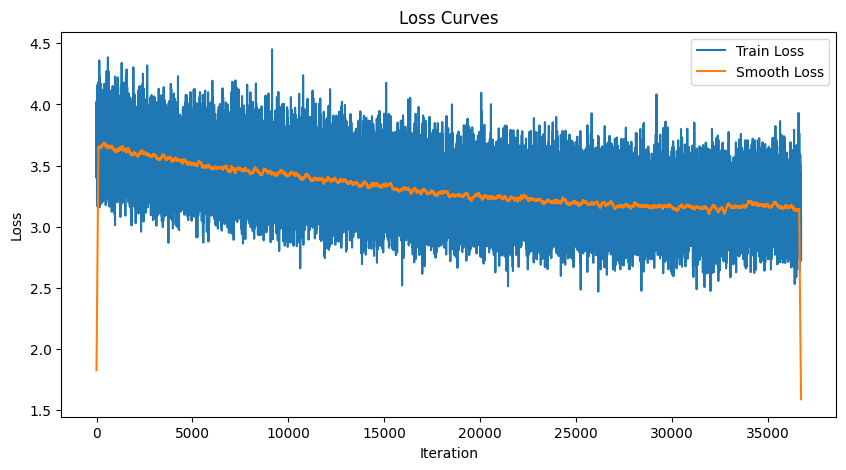

Evaluated 77 / 77   Total correctly classified: 35334/39229
Test Set Accuracy: 90.07%
F1: 0.6780446171760559


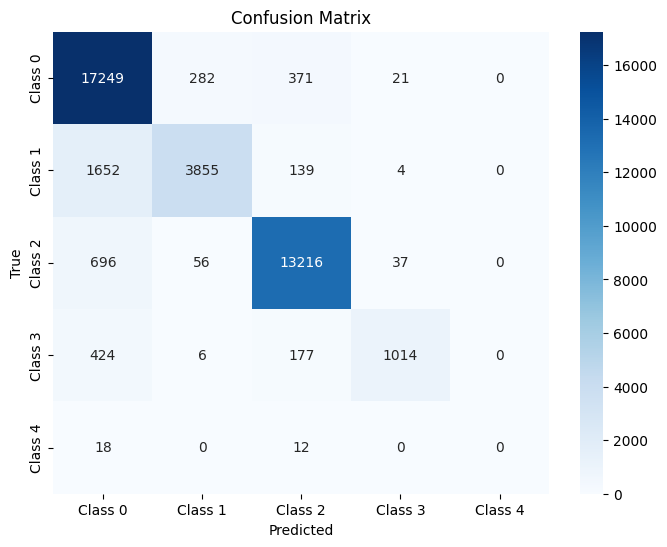

-----



In [31]:
net = None # cache a global net is useful


for hyper in hyperList:

    shyper = str(hyper) + str(recordNames)
    if (shyper in results) and False:
        print("Cached hyper", hyper)
        print(f"Test Set Accuracy: {100 * float(results[shyper]):.2f}%")
        continue
        
    print("Training for", hyper)
    startTime = time.time()
    
    net = hyper[0](hyper[1], hyper[2], hyper[3], 6)
    
    net.load_state_dict(torch.load("cps/net_weights_epoch_98_1770180458.pth"))

    loss_hist = train_net(net = net.to(device),
                          targetRegion = (0, windowSize),
                          lr = hyper[4],
                          num_epochs = hyper[5])

    print("\nFinished, time elapsed %.2f s" % (time.time()-startTime))
    plot_loss(loss_hist)
    accu = evaluate(net, (0, windowSize), test_loader)
    #accu = evaluate(net, (0, 360), test_loader, True)
    print("-----\n")

    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        results[shyper] = accu

        writer.writerow([shyper, accu])

# Analysis

In [ ]:
for fb in range(1, 12):
    hyper = hyperList[0]
    net = hyper[0](hyper[1], hyper[2], hyper[3], 6).to(device)
    net.load_state_dict(torch.load("net_weights_epoch_71_1769824900.pth"))

    net.qbits = 16
    net.fbits = fb
    print(fb)
    evaluate(net, (0, windowSize), test_loader, False)

17088


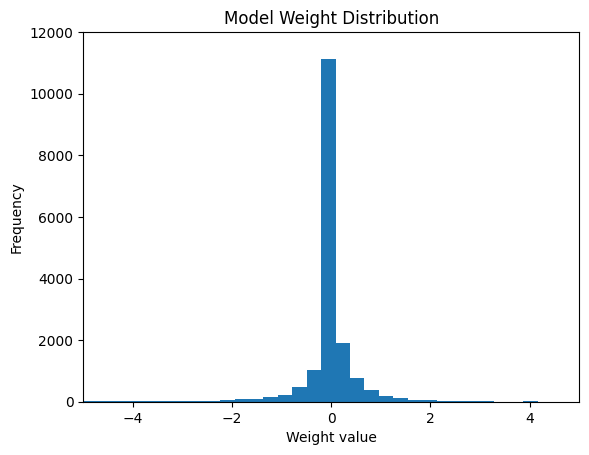

In [30]:
def plot_weight_histogram(model, bins=100, title="Model Weight Distribution"):
    """
    Plot a histogram of all trainable weights in a PyTorch model.
    
    Args:
        model (torch.nn.Module): PyTorch model
        bins (int): Number of histogram bins
        title (str): Plot title
    """
    weights = []

    for param in model.parameters():
        if param.requires_grad:
            weights.append(param.detach().cpu().flatten())

    if not weights:
        raise ValueError("No trainable parameters found in model")

    weights = torch.cat(weights).numpy()
    print(len(weights))

    plt.figure()
    plt.hist(weights, bins=bins)
    plt.title(title)
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.xlim(-5, 5)
    plt.ylim(0, 12000)
    plt.show()

def plot_weight_histograms_per_layer(model, bins=100):
    """
    Plot weight histograms for each trainable parameter tensor.
    
    Args:
        model (torch.nn.Module): PyTorch model
        bins (int): Number of histogram bins
    """
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        data = param.detach().cpu().flatten().numpy()

        plt.figure()
        plt.hist(data, bins=bins)
        plt.title(f"Weight Distribution: {name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()


hyper = hyperList[0]
net = hyper[0](hyper[1], hyper[2], hyper[3], 6).to(device)
net.load_state_dict(torch.load("cps/net_weights_epoch_115_1770227631.pth"))
#net.load_state_dict(torch.load("cps/net_weights_epoch_3299_100.pth"))
plot_weight_histogram(net)
#plot_weight_histograms_per_layer(net)


Evaluated 77 / 77   Total correctly classified: 35156/39229
Test Set Accuracy: 89.62%
F1: 0.6697971224784851


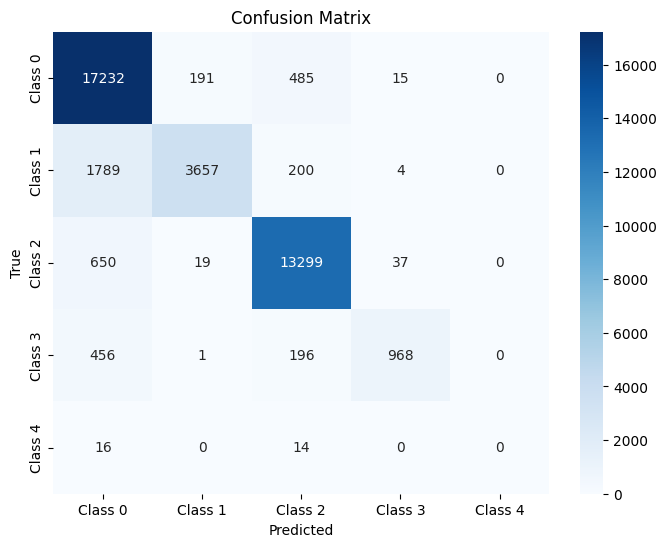

Evaluated 77 / 77   Total correctly classified: 34907/39229
Test Set Accuracy: 88.98%
F1: 0.6656001806259155


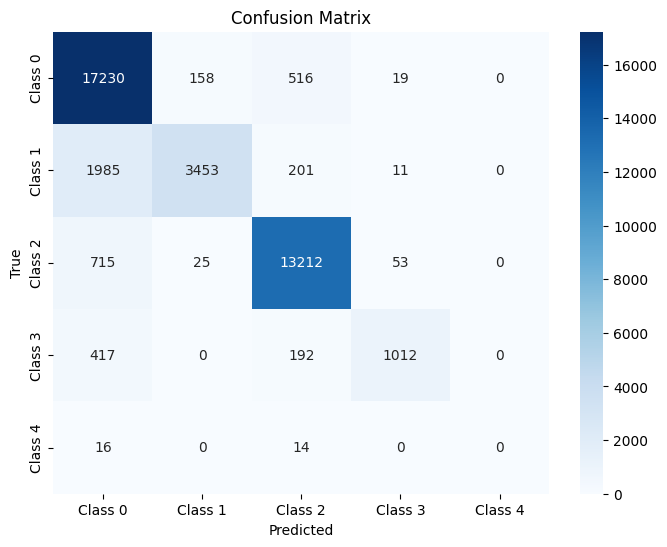

(0.8898264039358638, 288.4616470336914)

In [38]:
def clamp_model_weights(model, min_val, max_val):
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(min_val, max_val)
#net.load_state_dict(torch.load("net_weights_epoch_71_1769715119.pth"))
#evaluate(net, (0, windowSize), test_loader, False)
hyper = hyperList[0]
net = hyper[0](hyper[1], hyper[2], hyper[3], 6).to(device)
net.load_state_dict(torch.load("cps/net_weights_epoch_3299_100.pth"))
net.load_state_dict(torch.load("cps/net_weights_epoch_115_1770227631.pth"))
evaluate(net, (0, windowSize), test_loader, False)

net.load_state_dict(torch.load("cps/net_weights_epoch_115_1770227631.pth"))
clamp_model_weights(net, min_val=-6.0, max_val=6.0)
evaluate(net, (0, windowSize), test_loader, False)

In [ ]:
net.tally / test_size / 290

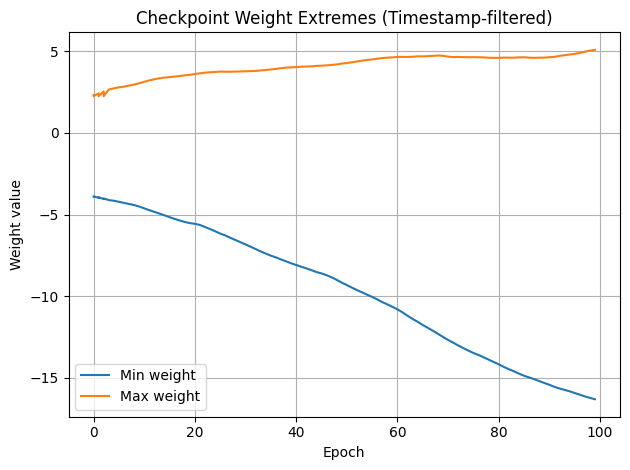

In [34]:
import os
import re
import torch
import matplotlib.pyplot as plt

# -------- config --------
ckpt_dir = "./cps"
pattern = r"net_weights_epoch_(\d+)_(\d+)\.pth"

# timestamp window (inclusive)
t_min = 1770170724
t_max = 2789723000

ldevice = "cpu"
# ------------------------

epochs = []
min_weights = []
max_weights = []

for fname in os.listdir(ckpt_dir):
    match = re.match(pattern, fname)
    if not match:
        continue

    epoch = int(match.group(1))
    timestamp = int(match.group(2))

    # filter by timestamp
    if not (t_min <= timestamp <= t_max):
        continue

    path = os.path.join(ckpt_dir, fname)

    state_dict = torch.load(path, map_location=ldevice)

    all_params = torch.cat([
        p.flatten() for p in state_dict.values()
        if torch.is_tensor(p)
    ])

    epochs.append(epoch)
    min_weights.append(all_params.min().item())
    max_weights.append(all_params.max().item())

# sort by epoch
epochs, min_weights, max_weights = zip(
    *sorted(zip(epochs, min_weights, max_weights))
)

# -------- plotting --------
plt.figure()
plt.plot(epochs, min_weights, label="Min weight")
plt.plot(epochs, max_weights, label="Max weight")
plt.xlabel("Epoch")
plt.ylabel("Weight value")
plt.title("Checkpoint Weight Extremes (Timestamp-filtered)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
